In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install tensorflow==1.13.1

     |████████████████████████████████| 92.5MB 58kB/s 
     |████████████████████████████████| 368kB 67.7MB/s 
     |████████████████████████████████| 3.2MB 72.1MB/s 
     |████████████████████████████████| 51kB 7.7MB/s 
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow 2.3.0
    Uninstalling tensorflow-2.3.0:
      Successfully uninstalled tensorflow-2.3.0


In [ ]:
! pip install tensorflow-gpu

     |████████████████████████████████| 320.4MB 45kB/s 


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import PIL.Image as pilimg
import os
import cv2
import time
import math

from itertools import repeat, chain
from glob import glob
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from keras.models import Model
from numpy.linalg import norm
from scipy.linalg import eigh
from gensim.models import Word2Vec

In [ ]:
cd drive/'My Drive'/shopping_mall

/content/drive/My Drive/shopping_mall


In [ ]:
! ls

checkpoint  img  img2


In [ ]:
temp =[4, 35, 59, 72, 84, 89, 161, 191, 257, 321, 413, 420, 625, 630, 715, 827, 842, 885, 910, 1004, 1014]

x_top = np.zeros((len(os.listdir('./img2'))-len(temp), 256, 256, 3), dtype=np.int32)
x_bottom = np.zeros((len(os.listdir('./img2'))-len(temp), 256, 256, 3), dtype=np.int32)
x_shoes = np.zeros((len(os.listdir('./img2'))-len(temp), 256, 256, 3), dtype=np.int32)
y_label = np.array(list(chain.from_iterable((repeat(number, len(os.listdir('./img2'))-len(temp)) for number in [0, 1, 2])))).reshape(-1, 1)
y_label = tf.keras.utils.to_categorical(y_label, num_classes=3, dtype='int32')

count = 0
for i, codi in enumerate(os.listdir('./img2')):
  if i in temp:
    continue
  
  for item in glob('./img2/' + codi + '/*.*'):
    data = np.array(pilimg.open(item))
    if data.shape[2] == 4:
      alpha1 = 0
      r2, g2, b2, alpha2 = 255, 255, 255, 255 
      red, green, blue, alpha = data[:,:,0], data[:,:,1], data[:,:,2], data[:,:,3]
      mask = (alpha==alpha1)
      data[:,:,:4][mask] = [r2, g2, b2, alpha2]
    item_arr = cv2.resize(data[:,:,:3], dsize=(256, 256), interpolation=cv2.INTER_LINEAR)

    category = item.split('/')[3].split('.')[0].strip()

    if item_arr.shape[2] == 2:
      print(i, category, item_arr.shape)
      continue
    if category == '상의':
      x_top[count,:,:,:] = item_arr
    elif category == '하의':
      x_bottom[count,:,:,:] = item_arr
    else:
      x_shoes[count,:,:,:] = item_arr
    
  count += 1

In [ ]:
x_top = np.zeros((len(os.listdir('./img'))-14, 256, 256, 3), dtype=np.int32)
x_bottom = np.zeros((len(os.listdir('./img'))-14, 256, 256, 3), dtype=np.int32)
x_shoes = np.zeros((len(os.listdir('./img'))-14, 256, 256, 3), dtype=np.int32)
y_label = np.array(list(chain.from_iterable((repeat(number, len(os.listdir('./img'))-14) for number in [0,1,2])))).reshape(-1, 1)
y_label = tf.keras.utils.to_categorical(y_label, num_classes=3, dtype='int32')

count = 0
for i, codi in enumerate(os.listdir('./img')):
  if i in [77, 110, 112, 126, 144, 145, 200, 229, 289, 299, 370, 390, 433, 441]:
    continue
  
  for item in glob('./img/' + codi + '/*.*'):
    data = np.array(pilimg.open(item))
    if data.shape[2] == 4:
      alpha1 = 0
      r2, g2, b2, alpha2 = 255, 255, 255, 255 
      red, green, blue, alpha = data[:,:,0], data[:,:,1], data[:,:,2], data[:,:,3]
      mask = (alpha==alpha1)
      data[:,:,:4][mask] = [r2, g2, b2, alpha2]
    item_arr = cv2.resize(data[:,:,:3], dsize=(256, 256), interpolation=cv2.INTER_LINEAR)

    category = item.split('/')[3].split('.')[0].strip()

    if item_arr.shape[2] == 2:
      print(i, category, item_arr.shape)
      continue
    if category == '상의':
      x_top[count,:,:,:] = item_arr
    elif category == '하의':
      x_bottom[count,:,:,:] = item_arr
    else:
      x_shoes[count,:,:,:] = item_arr
    
  count += 1

In [ ]:
print(x_top.shape, x_bottom.shape, x_shoes.shape)

(545, 256, 256, 3) (545, 256, 256, 3) (545, 256, 256, 3)


In [ ]:
x_data2 = np.vstack((x_top, x_bottom, x_shoes))
print(x_data2.shape, y_label.shape)

(1635, 256, 256, 3) (1635, 3)


In [ ]:
x_data = np.vstack((x_top, x_bottom, x_shoes))
print(x_data.shape, y_label.shape)

(3159, 256, 256, 3) (3159, 3)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_data, y_label, test_size=0.3, random_state=311)

In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1140, 256, 256, 3) (1140, 3) (489, 256, 256, 3) (489, 3)


In [ ]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset = dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

# iterator = dataset.make_one_shot_iterator()
# images, labels = iterator.get_next()
# print(images, labels)

In [ ]:
IMG_SHAPE = (256, 256, 3)

# 사전 훈련된 모델
base_model = tf.keras.applications.ResNet101(input_shape=IMG_SHAPE,
                                            include_top=False,
                                            weights='imagenet')

171450368/171446536 [==============================] - 8s 0us/step


In [ ]:
base_model.summary()

Model: "resnet101"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
__________________________________________________________________________________________

In [ ]:
base_model.trainable = True

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(3, activation='softmax')

model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101 (Functional)       (None, 8, 8, 2048)        42658176  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 6147      
Total params: 42,664,323
Trainable params: 42,558,979
Non-trainable params: 105,344
_________________________________________________________________


In [ ]:
os.getcwd()

'/content/drive/My Drive/shopping_mall'

In [ ]:
checkpoint_filepath = './checkpoint/weights.{epoch:02d}-{val_loss:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
hist = model.fit(dataset,
                 epochs=20,
                 verbose=1,
                 validation_data = (X_test, y_test),
                 callbacks=[model_checkpoint_callback])

Epoch 1/20
18/18 [==============================] - 11s 613ms/step - loss: 0.9642 - accuracy: 0.4939 - val_loss: 27.7310 - val_accuracy: 0.3374
Epoch 2/20
18/18 [==============================] - 8s 449ms/step - loss: 1.0865 - accuracy: 0.5096 - val_loss: 2156.8604 - val_accuracy: 0.3374
Epoch 3/20
18/18 [==============================] - 8s 450ms/step - loss: 0.8127 - accuracy: 0.6237 - val_loss: 722.4259 - val_accuracy: 0.3374
Epoch 4/20
18/18 [==============================] - 8s 450ms/step - loss: 0.5381 - accuracy: 0.8368 - val_loss: 104.3232 - val_accuracy: 0.3374
Epoch 5/20
18/18 [==============================] - 8s 449ms/step - loss: 0.5038 - accuracy: 0.7921 - val_loss: 52.7509 - val_accuracy: 0.3354
Epoch 6/20
18/18 [==============================] - 8s 449ms/step - loss: 0.2225 - accuracy: 0.9351 - val_loss: 46.4009 - val_accuracy: 0.3374
Epoch 7/20
18/18 [==============================] - 8s 449ms/step - loss: 0.1382 - accuracy: 0.9658 - val_loss: 9.2929 - val_accuracy: 0.

In [ ]:
checkpoint_filepath = './checkpoint/weight.{epoch:02d}-{val_loss:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
hist = model2.fit(dataset,
                 epochs=20,
                 verbose=1,
                 validation_data = (X_test, y_test),
                 callbacks=[model_checkpoint_callback])

Epoch 1/20
18/18 [==============================] - 11s 588ms/step - loss: 0.1826 - accuracy: 0.9491 - val_loss: 12.7984 - val_accuracy: 0.8671
Epoch 2/20
18/18 [==============================] - 9s 515ms/step - loss: 0.0891 - accuracy: 0.9833 - val_loss: 4.5556 - val_accuracy: 0.9100
Epoch 3/20
18/18 [==============================] - 8s 448ms/step - loss: 0.0315 - accuracy: 0.9895 - val_loss: 2.9302 - val_accuracy: 0.8548
Epoch 4/20
18/18 [==============================] - 9s 500ms/step - loss: 0.0124 - accuracy: 0.9947 - val_loss: 1.2609 - val_accuracy: 0.9550
Epoch 5/20
18/18 [==============================] - 9s 505ms/step - loss: 0.0048 - accuracy: 0.9982 - val_loss: 0.4972 - val_accuracy: 0.9652
Epoch 6/20
18/18 [==============================] - 9s 508ms/step - loss: 0.0046 - accuracy: 0.9974 - val_loss: 0.2993 - val_accuracy: 0.9734
Epoch 7/20
18/18 [==============================] - 9s 500ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.2362 - val_accuracy: 0.9775
Epoc

In [ ]:
y_pred = np.argmax(model.predict(X_test), axis=1)
y_pred

array([0, 0, 2, 1, 2, 1, 2, 0, 1, 1, 1, 0, 1, 1, 1, 0, 2, 1, 2, 0, 0, 1,
       1, 1, 0, 2, 0, 0, 0, 2, 1, 2, 0, 2, 1, 2, 1, 1, 1, 0, 1, 0, 0, 1,
       2, 0, 1, 2, 2, 1, 2, 2, 0, 0, 1, 0, 2, 1, 0, 1, 2, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 2, 0, 0, 1, 0, 1, 1, 1, 2, 0, 2, 0, 2, 2, 0, 0, 2,
       1, 0, 0, 1, 1, 0, 1, 0, 0, 2, 1, 0, 1, 1, 1, 0, 1, 0, 1, 2, 2, 1,
       1, 0, 2, 1, 2, 0, 2, 2, 0, 1, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 0, 2,
       2, 2, 0, 1, 0, 0, 0, 1, 2, 0, 2, 2, 2, 0, 1, 2, 1, 0, 2, 0, 1, 1,
       0, 1, 2, 1, 2, 1, 2, 2, 2, 2, 0, 2, 1, 1, 1, 1, 0, 2, 0, 2, 2, 2,
       1, 0, 2, 1, 2, 1, 2, 1, 2, 0, 1, 1, 2, 1, 1, 1, 1, 0, 2, 2, 0, 0,
       2, 2, 0, 1, 2, 2, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 2, 0, 0, 2, 0, 1, 2, 0, 2, 0, 1, 0, 0, 1, 1,
       0, 2, 0, 2, 1, 1, 1, 1, 2, 0, 1, 1, 1, 2, 1, 0, 0, 2, 0, 2, 2, 0,
       0, 0, 2, 2, 1, 1, 2, 1, 0, 2, 2, 0, 0, 0, 1, 1, 0, 0, 2, 2, 2, 0,
       2, 0, 0, 2, 0, 2, 1, 1, 2, 2, 1, 0, 1, 2, 0,

In [ ]:
confusion_matrix(y_pred, np.argmax(y_test, axis=1))

array([[157,   3,   3],
       [  2, 159,   0],
       [  1,   3, 161]])

In [ ]:
model.load_weights('./checkpoint/weights.18-0.10.hdf5')

y_pred = np.argmax(model.predict(x_data), axis=1)
confusion_matrix(y_pred, np.argmax(y_label, axis=1))

array([[1030,   13,    5],
       [  13, 1034,    4],
       [  10,    6, 1044]])

In [ ]:
model.load_weights('./checkpoint/weights.18-0.10.hdf5')

model_a = Model(inputs=model.inputs, outputs=model.layers[1].output)
model_a.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101_input (InputLayer) [(None, 256, 256, 3)]     0         
_________________________________________________________________
resnet101 (Functional)       (None, 8, 8, 2048)        42658176  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
Total params: 42,658,176
Trainable params: 42,552,832
Non-trainable params: 105,344
_________________________________________________________________


In [ ]:
df = pd.DataFrame(model_a.predict(x_data2))
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.000000,0.000000,1.351197,0.000000,0.006552,0.0,0.0,0.0,1.467118,0.503921,0.000000,0.0,0.0,0.188984,0.000000,0.000000,0.0,0.048412,1.137602,1.157012,0.000000,1.314324,0.000000,0.000000,0.129371,0.000000,0.000000,0.177629,0.000000,0.000000,0.0,1.172182,0.000000,0.124151,0.000000,0.231848,0.0,1.459518,0.275164,0.000000,...,0.0,0.000000,0.010267,0.456142,0.052122,0.000000,0.0,0.0,0.144197,0.118720,0.115788,0.814463,0.000000,0.0,0.000000,0.0,1.228544,0.085583,0.010635,0.000000,0.018259,0.075559,0.0,0.197859,0.0,0.0,0.010798,1.507485,0.039883,0.0,0.000000,0.000000,0.262575,0.134018,0.209186,0.022404,0.051758,0.000000,0.000000,0.556153
1,0.022701,0.000000,2.069827,0.000000,0.007357,0.0,0.0,0.0,2.173201,0.486967,0.000000,0.0,0.0,0.222773,0.000000,0.000000,0.0,0.026257,1.644078,1.744663,0.000000,1.941012,0.000000,0.000000,0.417390,0.000000,0.000000,0.729565,0.000000,0.000000,0.0,1.578904,0.000000,0.596940,0.033215,0.220305,0.0,2.063824,0.763617,0.000000,...,0.0,0.000000,0.009940,0.518426,0.000000,0.000000,0.0,0.0,0.089470,0.089009,0.612415,1.190676,0.015352,0.0,0.020629,0.0,1.840572,0.000000,0.000000,0.000000,0.059349,0.212683,0.0,0.360941,0.0,0.0,0.076934,2.091203,0.013986,0.0,0.000000,0.000000,0.266354,0.429052,0.212411,0.007202,0.000000,0.000000,0.000000,0.473039
2,0.008926,0.000000,2.008824,0.000000,0.000000,0.0,0.0,0.0,2.097973,0.276231,0.000000,0.0,0.0,0.089758,0.000000,0.000000,0.0,0.045517,1.624699,1.735384,0.000000,1.899085,0.000000,0.000000,0.525991,0.000000,0.000000,0.834574,0.000000,0.000000,0.0,1.529425,0.000000,0.694267,0.016549,0.086579,0.0,1.997641,0.776524,0.000000,...,0.0,0.000000,0.003712,0.528802,0.000000,0.005972,0.0,0.0,0.063024,0.151476,0.669907,1.220473,0.001514,0.0,0.008730,0.0,1.803557,0.000000,0.000000,0.000000,0.075948,0.098857,0.0,0.188979,0.0,0.0,0.070350,2.057220,0.030726,0.0,0.000000,0.000000,0.149334,0.508510,0.219174,0.001805,0.054374,0.000000,0.000000,0.561751
3,0.010650,0.000000,1.995146,0.000000,0.017867,0.0,0.0,0.0,2.072551,0.378030,0.000000,0.0,0.0,0.166346,0.000000,0.000000,0.0,0.000000,1.655027,1.716141,0.000000,1.914032,0.000000,0.000000,0.502904,0.000000,0.000000,0.843982,0.000000,0.000000,0.0,1.655866,0.000000,0.682675,0.039057,0.171186,0.0,2.049943,0.832081,0.000000,...,0.0,0.000000,0.023534,0.635320,0.000000,0.000000,0.0,0.0,0.076520,0.188808,0.683299,1.319379,0.000000,0.0,0.000000,0.0,1.771054,0.009618,0.000000,0.000000,0.019029,0.143182,0.0,0.221673,0.0,0.0,0.065070,2.064818,0.000000,0.0,0.000000,0.000000,0.176127,0.492240,0.279721,0.000000,0.125773,0.000000,0.000000,0.736317
4,0.000000,0.000000,1.794797,0.000000,0.000000,0.0,0.0,0.0,1.909307,0.339824,0.000000,0.0,0.0,0.204369,0.000000,0.000000,0.0,0.000000,1.501279,1.570422,0.000000,1.754967,0.000000,0.000000,0.473151,0.000000,0.000000,0.755709,0.000000,0.000000,0.0,1.459797,0.000000,0.590391,0.006104,0.211684,0.0,1.876075,0.791160,0.000000,...,0.0,0.000000,0.005143,0.597761,0.014549,0.000000,0.0,0.0,0.054496,0.076603,0.673579,1.038597,0.000000,0.0,0.000000,0.0,1.593224,0.000000,0.000000,0.000000,0.004175,0.141246,0.0,0.311867,0.0,0.0,0.028376,1.897002,0.000000,0.0,0.000000,0.000000,0.220904,0.548219,0.261879,0.000000,0.104367,0.000000,0.000000,0.497020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1630,0.683394,0.000000,0.274962,1.714236,0.000000,0.0,0.0,0.0,0.384367,0.000000,1.071795,0.0,0.0,0.000000,0.197176,0.051441,0.0,0.662011,0.202161,0.3106

In [ ]:
df['y'] = np.argmax(y_label, axis=1)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047,y
0,0.000000,0.000000,1.533267,0.000000,0.018177,0.0,0.0,0.0,1.613226,0.252093,0.000000,0.0,0.0,0.063905,0.000000,0.000000,0.0,0.000000,1.280084,1.302312,0.000000,1.463185,0.000000,0.000000,0.507594,0.000000,0.000000,0.800706,0.000000,0.000000,0.0,1.262004,0.000000,0.663106,0.044837,0.064074,0.0,1.542907,0.676363,0.000000,...,0.000000,0.008696,0.423415,0.000000,0.000000,0.0,0.0,0.056545,0.063417,0.620705,0.933631,0.000000,0.0,0.000000,0.000000,1.382671,0.000000,0.000000,0.000000,0.000000,0.050537,0.0,0.110708,0.0,0.0,0.017340,1.591969,0.000000,0.000000,0.000000,0.000000,0.148560,0.546267,0.210401,0.000000,0.073019,0.000000,0.000000,0.493499,0
1,0.039682,0.000000,2.293278,0.033914,0.024770,0.0,0.0,0.0,2.360232,0.446879,0.000000,0.0,0.0,0.207991,0.000000,0.000000,0.0,0.114079,1.874071,1.959975,0.000000,2.170597,0.004737,0.008858,0.350055,0.044951,0.000000,0.616077,0.019896,0.000000,0.0,1.806917,0.000000,0.418345,0.037530,0.237866,0.0,2.296751,0.596139,0.000000,...,0.000000,0.035097,0.650566,0.011896,0.000000,0.0,0.0,0.134527,0.162714,0.656300,1.483201,0.017421,0.0,0.003744,0.000000,2.012419,0.083537,0.021814,0.000000,0.086181,0.148690,0.0,0.341028,0.0,0.0,0.137408,2.314199,0.035738,0.000000,0.000000,0.000000,0.255234,0.418597,0.362064,0.026045,0.117082,0.000000,0.000000,0.683711,0
2,0.051882,0.000000,0.956665,0.000000,0.000000,0.0,0.0,0.0,1.027338,0.052807,0.000000,0.0,0.0,0.002232,0.000000,0.000000,0.0,0.086251,0.888853,0.864882,0.000000,1.003105,0.000000,0.006856,0.342869,0.004310,0.062881,0.546654,0.000000,0.000000,0.0,0.874215,0.000000,0.439503,0.023093,0.003459,0.0,1.043962,0.492404,0.000000,...,0.038596,0.028349,0.348600,0.000000,0.056195,0.0,0.0,0.017531,0.220129,0.328347,0.691733,0.000000,0.0,0.000000,0.000000,0.932043,0.020643,0.026951,0.000000,0.103357,0.000000,0.0,0.000000,0.0,0.0,0.030011,1.071564,0.062366,0.000000,0.000000,0.000000,0.044115,0.310871,0.218747,0.002065,0.209685,0.000000,0.000000,0.518073,0
3,0.010650,0.000000,1.995146,0.000000,0.017867,0.0,0.0,0.0,2.072551,0.378030,0.000000,0.0,0.0,0.166346,0.000000,0.000000,0.0,0.000000,1.655027,1.716141,0.000000,1.914032,0.000000,0.000000,0.502904,0.000000,0.000000,0.843982,0.000000,0.000000,0.0,1.655866,0.000000,0.682675,0.039057,0.171186,0.0,2.049943,0.832081,0.000000,...,0.000000,0.023534,0.635320,0.000000,0.000000,0.0,0.0,0.076520,0.188808,0.683299,1.319379,0.000000,0.0,0.000000,0.000000,1.771054,0.009618,0.000000,0.000000,0.019029,0.143182,0.0,0.221673,0.0,0.0,0.065070,2.064818,0.000000,0.000000,0.000000,0.000000,0.176127,0.492240,0.279721,0.000000,0.125773,0.000000,0.000000,0.736317,0
4,0.024037,0.000000,2.030749,0.000000,0.015619,0.0,0.0,0.0,2.100783,0.496638,0.000000,0.0,0.0,0.278031,0.000000,0.000000,0.0,0.000000,1.623224,1.727928,0.007775,1.899078,0.001195,0.000000,0.538111,0.000000,0.000000,0.938795,0.000000,0.000000,0.0,1.653857,0.000000,0.697543,0.028358,0.302919,0.0,2.035971,0.938334,0.000000,...,0.000000,0.048913,0.648009,0.043457,0.000000,0.0,0.0,0.181007,0.153166,0.885913,1.329996,0.000000,0.0,0.015378,0.000000,1.789125,0.000000,0.000000,0.000000,0.040218,0.125124,0.0,0.398815,0.0,0.0,0.077924,2.037393,0.000000,0.000000,0.000000,0.000000,0.249965,0.697481,0.420303,0.004824,0.162910,0.000000,0.000000,0.656112,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3154,0.970234,0.000000,0.000000,3.005336,0.000000,0.0,0.0,0.0,0.000000,0.361126,2.378112,0.0,0.0,0.161556,0.416021,

In [ ]:
np.random.seed(311)
rndperm = np.random.permutation(df.shape[0])

time_start = time.time()
N = 400
df_subset = df.copy()
data_subset = df_subset.values
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3159 samples in 0.696s...
[t-SNE] Computed neighbors for 3159 samples in 15.074s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3159
[t-SNE] Computed conditional probabilities for sample 2000 / 3159
[t-SNE] Computed conditional probabilities for sample 3000 / 3159
[t-SNE] Computed conditional probabilities for sample 3159 / 3159
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.426064
[t-SNE] KL divergence after 300 iterations: 1.080678
t-SNE done! Time elapsed: 19.835620164871216 seconds


In [ ]:
tsne_results.shape

(3159, 2)

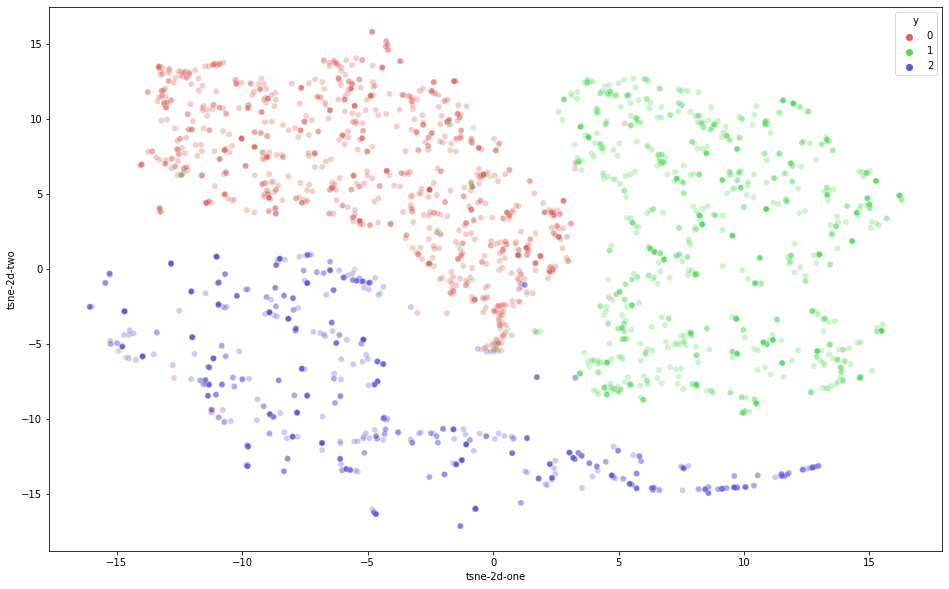

In [ ]:
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 3),
    data=df_subset,
    legend="full",
    alpha=0.3
)

In [ ]:
df_subset

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047,y,tsne-2d-one,tsne-2d-two
0,0.000000,0.000000,1.533267,0.000000,0.018177,0.0,0.0,0.0,1.613226,0.252093,0.000000,0.0,0.0,0.063905,0.000000,0.000000,0.0,0.000000,1.280084,1.302312,0.000000,1.463185,0.000000,0.000000,0.507594,0.000000,0.000000,0.800706,0.000000,0.000000,0.0,1.262004,0.000000,0.663106,0.044837,0.064074,0.0,1.542907,0.676363,0.000000,...,0.423415,0.000000,0.000000,0.0,0.0,0.056545,0.063417,0.620705,0.933631,0.000000,0.0,0.000000,0.000000,1.382671,0.000000,0.000000,0.000000,0.000000,0.050537,0.0,0.110708,0.0,0.0,0.017340,1.591969,0.000000,0.000000,0.000000,0.000000,0.148560,0.546267,0.210401,0.000000,0.073019,0.000000,0.000000,0.493499,0,-0.829760,5.499757
1,0.039682,0.000000,2.293278,0.033914,0.024770,0.0,0.0,0.0,2.360232,0.446879,0.000000,0.0,0.0,0.207991,0.000000,0.000000,0.0,0.114079,1.874071,1.959975,0.000000,2.170597,0.004737,0.008858,0.350055,0.044951,0.000000,0.616077,0.019896,0.000000,0.0,1.806917,0.000000,0.418345,0.037530,0.237866,0.0,2.296751,0.596139,0.000000,...,0.650566,0.011896,0.000000,0.0,0.0,0.134527,0.162714,0.656300,1.483201,0.017421,0.0,0.003744,0.000000,2.012419,0.083537,0.021814,0.000000,0.086181,0.148690,0.0,0.341028,0.0,0.0,0.137408,2.314199,0.035738,0.000000,0.000000,0.000000,0.255234,0.418597,0.362064,0.026045,0.117082,0.000000,0.000000,0.683711,0,-11.039437,11.841054
2,0.051882,0.000000,0.956665,0.000000,0.000000,0.0,0.0,0.0,1.027338,0.052807,0.000000,0.0,0.0,0.002232,0.000000,0.000000,0.0,0.086251,0.888853,0.864882,0.000000,1.003105,0.000000,0.006856,0.342869,0.004310,0.062881,0.546654,0.000000,0.000000,0.0,0.874215,0.000000,0.439503,0.023093,0.003459,0.0,1.043962,0.492404,0.000000,...,0.348600,0.000000,0.056195,0.0,0.0,0.017531,0.220129,0.328347,0.691733,0.000000,0.0,0.000000,0.000000,0.932043,0.020643,0.026951,0.000000,0.103357,0.000000,0.0,0.000000,0.0,0.0,0.030011,1.071564,0.062366,0.000000,0.000000,0.000000,0.044115,0.310871,0.218747,0.002065,0.209685,0.000000,0.000000,0.518073,0,2.181345,-0.612174
3,0.010650,0.000000,1.995146,0.000000,0.017867,0.0,0.0,0.0,2.072551,0.378030,0.000000,0.0,0.0,0.166346,0.000000,0.000000,0.0,0.000000,1.655027,1.716141,0.000000,1.914032,0.000000,0.000000,0.502904,0.000000,0.000000,0.843982,0.000000,0.000000,0.0,1.655866,0.000000,0.682675,0.039057,0.171186,0.0,2.049943,0.832081,0.000000,...,0.635320,0.000000,0.000000,0.0,0.0,0.076520,0.188808,0.683299,1.319379,0.000000,0.0,0.000000,0.000000,1.771054,0.009618,0.000000,0.000000,0.019029,0.143182,0.0,0.221673,0.0,0.0,0.065070,2.064818,0.000000,0.000000,0.000000,0.000000,0.176127,0.492240,0.279721,0.000000,0.125773,0.000000,0.000000,0.736317,0,-10.028410,8.705351
4,0.024037,0.000000,2.030749,0.000000,0.015619,0.0,0.0,0.0,2.100783,0.496638,0.000000,0.0,0.0,0.278031,0.000000,0.000000,0.0,0.000000,1.623224,1.727928,0.007775,1.899078,0.001195,0.000000,0.538111,0.000000,0.000000,0.938795,0.000000,0.000000,0.0,1.653857,0.000000,0.697543,0.028358,0.302919,0.0,2.035971,0.938334,0.000000,...,0.648009,0.043457,0.000000,0.0,0.0,0.181007,0.153166,0.885913,1.329996,0.000000,0.0,0.015378,0.000000,1.789125,0.000000,0.000000,0.000000,0.040218,0.125124,0.0,0.398815,0.0,0.0,0.077924,2.037393,0.000000,0.000000,0.000000,0.000000,0.249965,0.697481,0.420303,0.004824,0.162910,0.000000,0.000000,0.656112,0,-10.705465,7.930621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3154,0.970234,0.000000,0.000000,3.005336,0.000000,0.0,0.0,0.0,0.000000,0.361126,2.378112,0.0

In [ ]:
df_new = df_subset.iloc[:,:2049].reset_index()
df_new

,index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047,y
0,0,0.000000,0.000000,1.533267,0.000000,0.018177,0.0,0.0,0.0,1.613226,0.252093,0.000000,0.0,0.0,0.063905,0.000000,0.000000,0.0,0.000000,1.280084,1.302312,0.000000,1.463185,0.000000,0.000000,0.507594,0.000000,0.000000,0.800706,0.000000,0.000000,0.0,1.262004,0.000000,0.663106,0.044837,0.064074,0.0,1.542907,0.676363,...,0.000000,0.008696,0.423415,0.000000,0.000000,0.0,0.0,0.056545,0.063417,0.620705,0.933631,0.000000,0.0,0.000000,0.000000,1.382671,0.000000,0.000000,0.000000,0.000000,0.050537,0.0,0.110708,0.0,0.0,0.017340,1.591969,0.000000,0.000000,0.000000,0.000000,0.148560,0.546267,0.210401,0.000000,0.073019,0.000000,0.000000,0.493499,0
1,1,0.039682,0.000000,2.293278,0.033914,0.024770,0.0,0.0,0.0,2.360232,0.446879,0.000000,0.0,0.0,0.207991,0.000000,0.000000,0.0,0.114079,1.874071,1.959975,0.000000,2.170597,0.004737,0.008858,0.350055,0.044951,0.000000,0.616077,0.019896,0.000000,0.0,1.806917,0.000000,0.418345,0.037530,0.237866,0.0,2.296751,0.596139,...,0.000000,0.035097,0.650566,0.011896,0.000000,0.0,0.0,0.134527,0.162714,0.656300,1.483201,0.017421,0.0,0.003744,0.000000,2.012419,0.083537,0.021814,0.000000,0.086181,0.148690,0.0,0.341028,0.0,0.0,0.137408,2.314199,0.035738,0.000000,0.000000,0.000000,0.255234,0.418597,0.362064,0.026045,0.117082,0.000000,0.000000,0.683711,0
2,2,0.051882,0.000000,0.956665,0.000000,0.000000,0.0,0.0,0.0,1.027338,0.052807,0.000000,0.0,0.0,0.002232,0.000000,0.000000,0.0,0.086251,0.888853,0.864882,0.000000,1.003105,0.000000,0.006856,0.342869,0.004310,0.062881,0.546654,0.000000,0.000000,0.0,0.874215,0.000000,0.439503,0.023093,0.003459,0.0,1.043962,0.492404,...,0.038596,0.028349,0.348600,0.000000,0.056195,0.0,0.0,0.017531,0.220129,0.328347,0.691733,0.000000,0.0,0.000000,0.000000,0.932043,0.020643,0.026951,0.000000,0.103357,0.000000,0.0,0.000000,0.0,0.0,0.030011,1.071564,0.062366,0.000000,0.000000,0.000000,0.044115,0.310871,0.218747,0.002065,0.209685,0.000000,0.000000,0.518073,0
3,3,0.010650,0.000000,1.995146,0.000000,0.017867,0.0,0.0,0.0,2.072551,0.378030,0.000000,0.0,0.0,0.166346,0.000000,0.000000,0.0,0.000000,1.655027,1.716141,0.000000,1.914032,0.000000,0.000000,0.502904,0.000000,0.000000,0.843982,0.000000,0.000000,0.0,1.655866,0.000000,0.682675,0.039057,0.171186,0.0,2.049943,0.832081,...,0.000000,0.023534,0.635320,0.000000,0.000000,0.0,0.0,0.076520,0.188808,0.683299,1.319379,0.000000,0.0,0.000000,0.000000,1.771054,0.009618,0.000000,0.000000,0.019029,0.143182,0.0,0.221673,0.0,0.0,0.065070,2.064818,0.000000,0.000000,0.000000,0.000000,0.176127,0.492240,0.279721,0.000000,0.125773,0.000000,0.000000,0.736317,0
4,4,0.024037,0.000000,2.030749,0.000000,0.015619,0.0,0.0,0.0,2.100783,0.496638,0.000000,0.0,0.0,0.278031,0.000000,0.000000,0.0,0.000000,1.623224,1.727928,0.007775,1.899078,0.001195,0.000000,0.538111,0.000000,0.000000,0.938795,0.000000,0.000000,0.0,1.653857,0.000000,0.697543,0.028358,0.302919,0.0,2.035971,0.938334,...,0.000000,0.048913,0.648009,0.043457,0.000000,0.0,0.0,0.181007,0.153166,0.885913,1.329996,0.000000,0.0,0.015378,0.000000,1.789125,0.000000,0.000000,0.000000,0.040218,0.125124,0.0,0.398815,0.0,0.0,0.077924,2.037393,0.000000,0.000000,0.000000,0.000000,0.249965,0.697481,0.420303,0.004824,0.162910,0.000000,0.000000,0.656112,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3154,3154,0.970234,0.000000,0.000000,3.005336,0.000000,0.0,0.0,0.0,0.000000,0.361126,2.378112,0.0,0.0,0.161556,0.416021,0.102598,0.0,0.685775,0.000

In [ ]:
def cal_distance(v1, v2):
  return np.sqrt(sum(v1-v2)**2)

def near(idx):
  label = df_new[df_new['index'] == idx]['y']
  temp = df_new[df_new['y'] == label.iloc[0]]

  result = []
  for i in temp['index']:
    v1 = np.array(df_new[df_new['index'] == idx].iloc[:, 1:2049]).reshape(-1)
    v2 = np.array(df_new[df_new['index'] == i].iloc[:, 1:2049]).reshape(-1)
    if i != idx:
      result.append((i, cal_distance(v1, v2)))

  final = [idx]
  final.extend(list(map(lambda x: x[0], sorted(result, key=lambda x: x[1])[:5])))

  width = 10
  height = 10
  rows = 2
  cols = 3
  axes = []
  fig = plt.figure(figsize=(width, height))

  for a, b in zip(range(rows*cols), final):
      axes.append( fig.add_subplot(rows, cols, a+1) )
      subplot_title=("Top-"+str(a))
      axes[-1].set_title(subplot_title)  
      plt.imshow(x_data[b])
  fig.tight_layout()    
  plt.show()

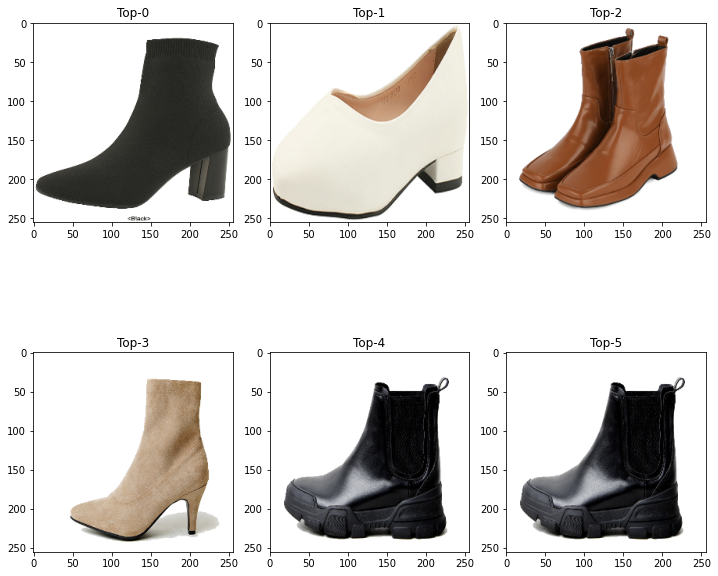

In [ ]:
# 1238, 1242? 1271
near(2244)

# codi 추천

In [ ]:
top_arr = model_a.predict(x_top)
bottom_arr = model_a.predict(x_bottom)
shoes_arr = model_a.predict(x_shoes)

In [ ]:
print(top_arr.shape, bottom_arr.shape, shoes_arr.shape)

(545, 2048) (545, 2048) (545, 2048)


In [ ]:
# codi = np.zeros((top_arr.shape[0], top_arr.shape[1], 3), dtype=np.float32)


# for idx, t, b, s in zip([x for x in range(len(top_arr))], top_arr, bottom_arr, shoes_arr):
#   codi[idx, :, 0] = t
#   codi[idx, :, 1] = b
#   codi[idx, :, 2] = s

# codi.shape


codi = np.c_[top_arr, bottom_arr, shoes_arr]

codi.shape

(545, 6144)

In [ ]:
df2 = pd.DataFrame(codi)
df2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,6104,6105,6106,6107,6108,6109,6110,6111,6112,6113,6114,6115,6116,6117,6118,6119,6120,6121,6122,6123,6124,6125,6126,6127,6128,6129,6130,6131,6132,6133,6134,6135,6136,6137,6138,6139,6140,6141,6142,6143
0,0.000000,0.0,1.351197,0.000000,0.006552,0.0,0.0,0.0,1.467118,0.503921,0.0,0.0,0.0,0.188984,0.0,0.0,0.0,0.048412,1.137602,1.157012,0.000000,1.314324,0.00000,0.000000,0.129371,0.000000,0.000000,0.177629,0.000000,0.000000,0.0,1.172182,0.0,0.124151,0.000000,0.231848,0.0,1.459518,0.275164,0.0,...,0.0,0.626064,0.105779,0.171089,0.000000,0.640308,0.0,0.0,0.000000,0.400543,0.000000,0.184117,0.000000,0.0,0.274647,0.000000,0.418209,0.924318,0.895261,0.333560,0.316002,0.020584,0.0,0.000000,0.0,0.0,0.298753,0.473998,0.870884,0.000000,0.032777,0.073213,0.058527,0.000000,0.078225,0.325391,0.061676,0.040026,0.000000,0.145688
1,0.022701,0.0,2.069827,0.000000,0.007357,0.0,0.0,0.0,2.173201,0.486967,0.0,0.0,0.0,0.222773,0.0,0.0,0.0,0.026257,1.644078,1.744663,0.000000,1.941012,0.00000,0.000000,0.417390,0.000000,0.000000,0.729565,0.000000,0.000000,0.0,1.578904,0.0,0.596940,0.033215,0.220305,0.0,2.063824,0.763617,0.0,...,0.0,0.631852,0.161714,0.017422,0.034443,0.532791,0.0,0.0,0.000000,0.300496,0.000000,0.140405,0.000000,0.0,0.376474,0.012167,0.022512,0.657381,0.682805,0.052081,0.413336,0.000000,0.0,0.000000,0.0,0.0,0.348792,0.000000,0.665960,0.000000,0.000000,0.070453,0.000000,0.025773,0.000000,0.359755,0.020786,0.000000,0.000000,0.047394
2,0.008926,0.0,2.008824,0.000000,0.000000,0.0,0.0,0.0,2.097973,0.276231,0.0,0.0,0.0,0.089758,0.0,0.0,0.0,0.045517,1.624699,1.735384,0.000000,1.899085,0.00000,0.000000,0.525991,0.000000,0.000000,0.834574,0.000000,0.000000,0.0,1.529425,0.0,0.694267,0.016549,0.086579,0.0,1.997641,0.776524,0.0,...,0.0,1.357364,0.297195,0.000000,0.046524,1.061778,0.0,0.0,0.045249,0.255479,0.036757,0.242273,0.000000,0.0,0.187028,0.000000,0.000000,0.610582,1.068018,0.317782,0.490757,0.014280,0.0,0.096023,0.0,0.0,1.024517,0.000000,0.728252,0.000000,0.039282,0.325499,0.156639,0.085452,0.000000,0.197374,0.201005,0.102925,0.029637,0.116516
3,0.010650,0.0,1.995146,0.000000,0.017867,0.0,0.0,0.0,2.072551,0.378030,0.0,0.0,0.0,0.166346,0.0,0.0,0.0,0.000000,1.655027,1.716141,0.000000,1.914032,0.00000,0.000000,0.502904,0.000000,0.000000,0.843982,0.000000,0.000000,0.0,1.655866,0.0,0.682675,0.039057,0.171186,0.0,2.049943,0.832081,0.0,...,0.0,8.955580,0.234181,0.013012,0.218110,1.468598,0.0,0.0,0.303644,0.448709,0.496298,1.670830,0.031604,0.0,0.098782,0.000000,0.030892,0.647225,2.830415,0.595341,0.287623,0.039775,0.0,2.981639,0.0,0.0,6.744517,0.026186,0.406404,0.013926,0.123550,1.937295,1.769565,0.651030,0.000000,0.098932,4.094936,1.728285,0.589124,0.993019
4,0.000000,0.0,1.794797,0.000000,0.000000,0.0,0.0,0.0,1.909307,0.339824,0.0,0.0,0.0,0.204369,0.0,0.0,0.0,0.000000,1.501279,1.570422,0.000000,1.754967,0.00000,0.000000,0.473151,0.000000,0.000000,0.755709,0.000000,0.000000,0.0,1.459797,0.0,0.590391,0.006104,0.211684,0.0,1.876075,0.791160,0.0,...,0.0,5.837705,0.149450,0.099334,0.113836,1.485174,0.0,0.0,0.153978,0.261456,0.000000,1.172108,0.007790,0.0,0.225205,0.000000,0.327833,1.003874,2.658535,0.526275,0.205731,0.004095,0.0,1.474416,0.0,0.0,4.277119,0.381197,0.640024,0.000000,0.059261,1.349648,1.044433,0.000000,0.000000,0.278277,1.995244,0.853462,0.324738,0.736024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,0.030485,0.0,2.061382,0.000000,0.000000,0.0,0.0,0.0,2.152454,0.639182,0.0,0.0,0.0,0.360893,0.0,0.0,0.0,0.000000,1.650847,1.745419,0.000000,1.934720,0.00000,0.004245,0.662314,0.000000,0.000000,1.158208,0.000000,0.000000,0.0,1.667775,0.0,0.907321,0.024208

In [ ]:
num_clusters = 5

km = KMeans(n_clusters=num_clusters)
km.fit(df2)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
df2['cluster'] = km.labels_
df2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,6105,6106,6107,6108,6109,6110,6111,6112,6113,6114,6115,6116,6117,6118,6119,6120,6121,6122,6123,6124,6125,6126,6127,6128,6129,6130,6131,6132,6133,6134,6135,6136,6137,6138,6139,6140,6141,6142,6143,cluster
0,0.000000,0.0,1.351197,0.000000,0.006552,0.0,0.0,0.0,1.467118,0.503921,0.0,0.0,0.0,0.188984,0.0,0.0,0.0,0.048412,1.137602,1.157012,0.000000,1.314324,0.00000,0.000000,0.129371,0.000000,0.000000,0.177629,0.000000,0.000000,0.0,1.172182,0.0,0.124151,0.000000,0.231848,0.0,1.459518,0.275164,0.0,...,0.626064,0.105779,0.171089,0.000000,0.640308,0.0,0.0,0.000000,0.400543,0.000000,0.184117,0.000000,0.0,0.274647,0.000000,0.418209,0.924318,0.895261,0.333560,0.316002,0.020584,0.0,0.000000,0.0,0.0,0.298753,0.473998,0.870884,0.000000,0.032777,0.073213,0.058527,0.000000,0.078225,0.325391,0.061676,0.040026,0.000000,0.145688,1
1,0.022701,0.0,2.069827,0.000000,0.007357,0.0,0.0,0.0,2.173201,0.486967,0.0,0.0,0.0,0.222773,0.0,0.0,0.0,0.026257,1.644078,1.744663,0.000000,1.941012,0.00000,0.000000,0.417390,0.000000,0.000000,0.729565,0.000000,0.000000,0.0,1.578904,0.0,0.596940,0.033215,0.220305,0.0,2.063824,0.763617,0.0,...,0.631852,0.161714,0.017422,0.034443,0.532791,0.0,0.0,0.000000,0.300496,0.000000,0.140405,0.000000,0.0,0.376474,0.012167,0.022512,0.657381,0.682805,0.052081,0.413336,0.000000,0.0,0.000000,0.0,0.0,0.348792,0.000000,0.665960,0.000000,0.000000,0.070453,0.000000,0.025773,0.000000,0.359755,0.020786,0.000000,0.000000,0.047394,1
2,0.008926,0.0,2.008824,0.000000,0.000000,0.0,0.0,0.0,2.097973,0.276231,0.0,0.0,0.0,0.089758,0.0,0.0,0.0,0.045517,1.624699,1.735384,0.000000,1.899085,0.00000,0.000000,0.525991,0.000000,0.000000,0.834574,0.000000,0.000000,0.0,1.529425,0.0,0.694267,0.016549,0.086579,0.0,1.997641,0.776524,0.0,...,1.357364,0.297195,0.000000,0.046524,1.061778,0.0,0.0,0.045249,0.255479,0.036757,0.242273,0.000000,0.0,0.187028,0.000000,0.000000,0.610582,1.068018,0.317782,0.490757,0.014280,0.0,0.096023,0.0,0.0,1.024517,0.000000,0.728252,0.000000,0.039282,0.325499,0.156639,0.085452,0.000000,0.197374,0.201005,0.102925,0.029637,0.116516,1
3,0.010650,0.0,1.995146,0.000000,0.017867,0.0,0.0,0.0,2.072551,0.378030,0.0,0.0,0.0,0.166346,0.0,0.0,0.0,0.000000,1.655027,1.716141,0.000000,1.914032,0.00000,0.000000,0.502904,0.000000,0.000000,0.843982,0.000000,0.000000,0.0,1.655866,0.0,0.682675,0.039057,0.171186,0.0,2.049943,0.832081,0.0,...,8.955580,0.234181,0.013012,0.218110,1.468598,0.0,0.0,0.303644,0.448709,0.496298,1.670830,0.031604,0.0,0.098782,0.000000,0.030892,0.647225,2.830415,0.595341,0.287623,0.039775,0.0,2.981639,0.0,0.0,6.744517,0.026186,0.406404,0.013926,0.123550,1.937295,1.769565,0.651030,0.000000,0.098932,4.094936,1.728285,0.589124,0.993019,0
4,0.000000,0.0,1.794797,0.000000,0.000000,0.0,0.0,0.0,1.909307,0.339824,0.0,0.0,0.0,0.204369,0.0,0.0,0.0,0.000000,1.501279,1.570422,0.000000,1.754967,0.00000,0.000000,0.473151,0.000000,0.000000,0.755709,0.000000,0.000000,0.0,1.459797,0.0,0.590391,0.006104,0.211684,0.0,1.876075,0.791160,0.0,...,5.837705,0.149450,0.099334,0.113836,1.485174,0.0,0.0,0.153978,0.261456,0.000000,1.172108,0.007790,0.0,0.225205,0.000000,0.327833,1.003874,2.658535,0.526275,0.205731,0.004095,0.0,1.474416,0.0,0.0,4.277119,0.381197,0.640024,0.000000,0.059261,1.349648,1.044433,0.000000,0.000000,0.278277,1.995244,0.853462,0.324738,0.736024,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,0.030485,0.0,2.061382,0.000000,0.000000,0.0,0.0,0.0,2.152454,0.639182,0.0,0.0,0.0,0.360893,0.0,0.0,0.0,0.000000,1.650847,1.745419,0.000000,1.934720,0.00000,0.004245,0.662314,0.000000,0.000000,1.158208,0.000000,0.000000,0.0,1.667775,0.0,0.907321,0.024208,0.3648

In [ ]:
df2['cluster'].value_counts()

2    450
4    231
0    206
3    123
1     43
Name: cluster, dtype: int64

In [ ]:
np.random.seed(311)

time_start = time.time()
df_subset2 = df2.copy()
data_subset2 = df_subset2.values
tsne2 = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=400)
tsne_results2 = tsne2.fit_transform(data_subset2)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 545 samples in 0.257s...
[t-SNE] Computed neighbors for 545 samples in 2.730s...
[t-SNE] Computed conditional probabilities for sample 545 / 545
[t-SNE] Mean sigma: 5.921785
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.638210
[t-SNE] KL divergence after 400 iterations: 0.551840
t-SNE done! Time elapsed: 3.9852097034454346 seconds


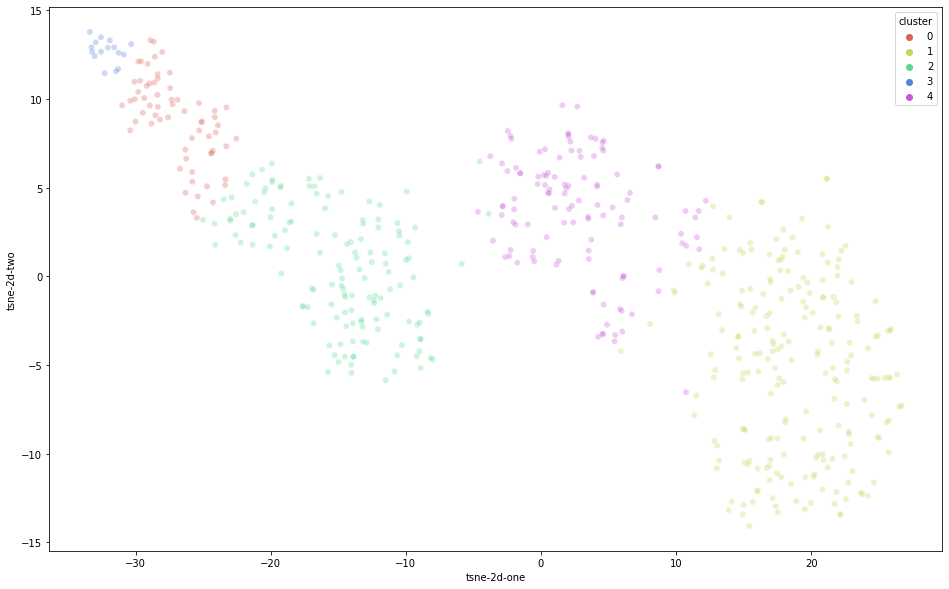

In [ ]:
df_subset2['tsne-2d-one'] = tsne_results2[:,0]
df_subset2['tsne-2d-two'] = tsne_results2[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="cluster",
    palette=sns.color_palette("hls", 5),
    data=df_subset2,
    legend="full",
    alpha=0.3
)

In [ ]:
def cos_sim(A, B):
  return np.dot(A, B)/(norm(A)*norm(B))


def recommend_codi(idx):
  cls = df2.loc[idx]['cluster']

  temp = df2[df2['cluster'] == cls]

  lst = []
  for i in temp.index:
    if i in [idx, 543, 544, 545]:
      continue
    lst.append((i, cos_sim(temp.loc[idx], temp.loc[i])))

  final = sorted(lst, key=lambda x: x[1])[0][0]

  print(final)
  axes = []
  fig = plt.figure(figsize=(10, 10))
  for i, j in zip(range(1, 7), ['Top', 'Top', 'bottom', 'bottom', 'shoes', 'shoes']):
    final_idx = 0
    axes.append(fig.add_subplot(3, 2, i))
    string = ''
    if i % 2 == 1:
      string = 'Original'
      final_idx = idx
    else:
      string = 'Recommend'
      final_idx = final

    subplot_title = string + '_' + j
    axes[-1].set_title(subplot_title)

    if i in [1, 2]:
      plt.imshow(x_top[final_idx])
    elif i in [3, 4]:
      plt.imshow(x_bottom[final_idx])
    else:
      plt.imshow(x_shoes[final_idx])
    
  
  fig.tight_layout()    
  plt.show()

191


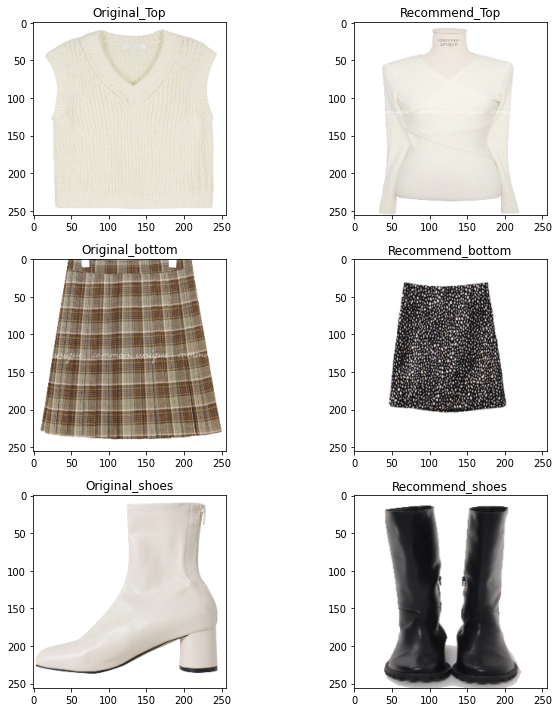

In [ ]:
# 110 111
recommend_codi(35)

# 태그 사용

In [ ]:
dic = {1: ['심플'],
 2: ['겨울'],
 3: ['스니커즈', '간단'],
 4: ['코트', '니트'],
 5: ['베이지'],
 6: ['코트', '체크'],
 7: ['겨울코트', '시크', '코트'],
 8: ['여대생룩'],
 9: ['겨울', '숏패딩'],
 10: ['심플', '베이직'],
 11: ['데일리'],
 12: ['캐주얼'],
 13: ['니트'],
 14: ['니트'],
 15: ['코트'],
 16: ['니트'],
 17: ['니트'],
 18: ['심플룩'],
 19: ['스커트'],
 20: ['베이지'],
 21: ['원피스'],
 22: ['데일리', '모던시크', '깔끔'],
 23: ['코트'],
 24: ['데일리'],
 25: ['숏패딩'],
 26: ['컨버스', '캐주얼'],
 27: ['데이트', '원피스'],
 28: ['캐주얼룩'],
 29: ['자켓'],
 30: ['부츠'],
 31: ['겨울'],
 32: ['간단'],
 33: ['베이직'],
 34: ['코트'],
 35: ['꾸안꾸'],
 36: ['겨울'],
 37: ['숏패딩'],
 38: ['간편'],
 39: ['브라운'],
 40: ['가디건'],
 41: ['코트', '스니커즈'],
 42: ['데일리', '코트'],
 43: ['자켓'],
 44: ['부츠'],
 45: ['숏패딩'],
 46: ['니트'],
 47: ['블랙'],
 48: ['꾸안꾸'],
 49: ['자켓'],
 50: ['빈티지', '목폴라니트', '무스탕'],
 51: ['mint'],
 52: ['데일리'],
 53: ['심플'],
 54: ['베이지'],
 55: ['베이지'],
 56: ['간편'],
 57: ['숏패딩'],
 58: ['겨울데일리룩'],
 59: ['블랙'],
 60: ['아가일니트'],
 61: ['심플', '코트'],
 62: ['레오파드'],
 63: ['캐주얼룩'],
 64: ['오오티디', '코트'],
 65: ['심플'],
 66: ['겨울'],
 67: ['깔끔단정', '캐주얼룩'],
 68: ['니트', '심플'],
 69: ['겨울'],
 70: ['간편하게', '니트'],
 71: ['가디건'],
 72: ['데일리룩'],
 73: ['부츠'],
 74: ['여대생룩'],
 75: ['늦가을'],
 76: ['캐주얼'],
 77: ['꾸안꾸'],
 78: ['숏패딩'],
 79: ['브라운'],
 80: ['겨울'],
 81: ['베이지'],
 82: ['코트'],
 83: ['브라운'],
 84: ['오오티디', '가을'],
 85: ['자켓'],
 86: ['빈티지'],
 87: ['심플'],
 88: ['퀄팅'],
 89: ['심플', '시크'],
 90: ['가을', '자켓'],
 91: ['니트원피스'],
 92: ['베이직', '편하게'],
 93: ['겨울'],
 94: ['심플'],
 95: ['자켓'],
 96: ['데일리', '여행'],
 97: ['가디건', '데님'],
 98: ['코트'],
 99: ['자켓'],
 100: ['모던', '니트'],
 101: ['스니커즈'],
 102: ['데일리', '코트'],
 103: ['자켓'],
 104: ['시크'],
 105: ['데일리', '코트'],
 106: ['가을의색'],
 107: ['간편'],
 108: ['패딩', '체크팬츠'],
 109: ['오오티디', '대학생'],
 110: ['심플', '로퍼'],
 111: ['자켓'],
 112: ['코트'],
 113: ['코트'],
 114: ['심플'],
 115: ['심플'],
 116: ['겨울'],
 117: ['체크원피스'],
 118: ['자켓'],
 119: ['꾸안꾸', '편하게'],
 120: ['코트'],
 121: ['가을'],
 122: ['심플', '자켓'],
 123: ['나는집순이'],
 124: ['빈티지', 'coat', 'simple'],
 125: ['스니커즈'],
 126: ['베이지'],
 127: ['코트'],
 128: ['코트'],
 129: ['여대생룩'],
 130: ['겨울'],
 131: ['코트'],
 132: ['겨울list'],
 133: ['브라운'],
 134: ['데일리', '레이어드'],
 135: ['꾸안꾸'],
 136: ['니트'],
 137: ['코트', '블랙'],
 138: ['심플룩', '브라운'],
 139: ['paris'],
 140: ['겨울'],
 141: ['베레모', '블랙'],
 142: ['자켓'],
 143: ['스니커즈'],
 144: ['캐주얼'],
 145: ['심플', '베이지', '가디건'],
 146: ['자켓', '빈티지', '베레모'],
 147: ['니트'],
 148: ['니트'],
 149: ['체크'],
 150: ['코트'],
 151: ['브라운'],
 152: ['가죽', '레오파드'],
 153: ['chic', '여성스러운'],
 154: ['자켓', '심플'],
 155: ['캐주얼'],
 156: ['데일리', '겨울', '데이트'],
 157: ['깔끔'],
 158: ['자켓'],
 159: ['레이어드', '심플'],
 160: ['자켓'],
 161: ['자켓'],
 162: ['가디건'],
 163: ['꾸안꾸', '겨울', '패딩'],
 164: ['가을데일리'],
 165: ['레이어드'],
 166: ['가디건'],
 167: ['심플'],
 168: ['자켓'],
 169: ['심플'],
 170: ['오피스룩'],
 171: ['부츠'],
 172: ['맨투맨'],
 173: ['가디건'],
 174: ['원피스'],
 175: ['초겨울'],
 176: ['베이지'],
 177: ['셔츠', '자켓'],
 178: ['캐주얼'],
 179: ['심플'],
 180: ['캐주얼'],
 181: ['자켓'],
 182: ['니트'],
 183: ['시크'],
 184: ['겨울준비', '니트조끼', '데님', '캐주얼'],
 185: ['가디건'],
 186: ['브라운', '롱스커트'],
 187: ['코트'],
 188: ['겨울'],
 189: ['겨울', '레이어드'],
 190: ['퍼', '겨울'],
 191: ['니트'],
 192: ['추운', '겨울'],
 193: ['퍼', '겨울'],
 194: ['모던', '겨울', '니트', '코트'],
 195: ['겨울'],
 196: ['니트'],
 197: ['코트'],
 198: ['코트'],
 199: ['자켓'],
 200: ['심플', '깔끔'],
 201: ['가을룩', '데일리'],
 202: ['스커트', '심플'],
 203: ['캐주얼'],
 204: ['오렌지', '베이지', '자켓'],
 205: ['꾸안꾸'],
 206: ['오피스룩', '심플룩', '코트'],
 207: ['레이어드', '코트'],
 208: ['denim'],
 209: ['브라운', '깔끔단정', '자켓'],
 210: ['패딩'],
 211: ['추운날씨', '후드티'],
 212: ['그레이'],
 213: ['심플', '니트', '대학생'],
 214: ['꾸안꾸', '겨울'],
 215: ['가디건'],
 216: ['캐주얼', '니트조끼'],
 217: ['가디건'],
 218: ['자켓'],
 219: ['대학생룩', '가디건', '자켓'],
 220: ['심플'],
 221: ['겨울'],
 222: ['니트', '그린'],
 223: ['자켓'],
 224: ['심플', '니트'],
 225: ['블랙'],
 226: ['니트'],
 227: ['니트', '자켓'],
 228: ['꾸안꾸'],
 229: ['가디건'],
 230: ['심플'],
 231: ['가을'],
 232: ['코트'],
 233: ['심플'],
 234: ['가을', '코트'],
 235: ['가을'],
 236: ['가을'],
 237: ['자켓'],
 238: ['가디건'],
 239: ['깔끔'],
 240: ['가을'],
 241: ['심플'],
 242: ['니트'],
 243: ['beige'],
 244: ['심플', '아메카지'],
 245: ['코트'],
 246: ['autumn'],
 247: ['겨울'],
 248: ['가을'],
 249: ['가디건'],
 250: ['코트'],
 251: ['베이지'],
 252: ['캐주얼'],
 253: ['가을'],
 254: ['오피스룩'],
 255: ['간편하게'],
 256: ['가디건'],
 257: ['학생룩', '하이틴'],
 258: ['맨투맨'],
 259: ['맨투맨'],
 260: ['자켓', 'black'],
 261: ['시크', '심플'],
 262: ['코트'],
 263: ['니트', '자켓'],
 264: ['깔끔'],
 265: ['자켓', '원피스'],
 266: ['가디건'],
 267: ['가디건'],
 268: ['니트'],
 269: ['가을'],
 270: ['스커트'],
 271: ['겨울'],
 272: ['자켓', '베레모'],
 273: ['자켓', '심플'],
 274: ['가디건'],
 275: ['여대생룩'],
 276: ['가을'],
 277: ['빈티지'],
 278: ['자켓', '심플룩'],
 279: ['셔츠', '가을'],
 280: ['데일리', '일상'],
 281: ['심플'],
 282: ['심플'],
 283: ['베이지'],
 284: ['가을데이트', '자켓'],
 285: ['자켓'],
 286: ['빈티지'],
 287: ['가을데이트'],
 288: ['가을'],
 289: ['캐주얼룩'],
 290: ['코트'],
 291: ['자켓'],
 292: ['데일리', '가을'],
 293: ['아메카지'],
 294: ['뽀글이'],
 295: ['트렌치코트'],
 296: ['깔끔단정'],
 297: ['가을'],
 298: ['블랙'],
 299: ['가디건'],
 300: ['셔츠', '가을'],
 301: ['심플', '데님'],
 302: ['캐주얼룩'],
 303: ['깔끔단정', '심플'],
 304: ['모던', '일상적', '심플'],
 305: ['오피스'],
 306: ['캐주얼'],
 307: ['가을룩'],
 308: ['깔끔', '오오티디'],
 309: ['가을'],
 310: ['깔끔단정', '부츠'],
 311: ['캠퍼스', '편하게'],
 312: ['가디건', '가을캐주얼'],
 313: ['캐쥬얼룩'],
 314: ['니트'],
 315: ['유니크', '캐주얼룩'],
 316: ['레트로', '데님', '스커트'],
 317: ['캐주얼룩', '여대생룩'],
 318: ['심플코디', '간단'],
 319: ['가죽'],
 320: ['가디건', '깔끔'],
 321: ['심플'],
 322: ['심플', '데님'],
 323: ['꾸안꾸', '가디건'],
 324: ['깔끔', '자켓'],
 325: ['니트'],
 326: ['심플', '베이지', '깔끔'],
 327: ['꾸안꾸'],
 328: ['자켓'],
 329: ['코트'],
 330: ['깔끔', '가디건'],
 331: ['베이지', '추운'],
 332: ['데님', '가죽'],
 333: ['꾸안꾸', '베이지'],
 334: ['빈티지'],
 335: ['심플', '가디건'],
 336: ['가을', '트렌치코트'],
 337: ['캐쥬얼룩', '편하게', '이쁨'],
 338: ['그린', '트위드', 'Emilyinparis', '코디'],
 339: ['겨울코트', '캐주얼룩', 'Emilyinparis', '영화코디'],
 340: ['영화', '에밀리파리에가다', '패션', 'Emilyinparis'],
 341: ['Emilyinparis', '영화', '에밀리파리에가다', '패션'],
 342: ['귀여운', '캐주얼룩', '겨울코디'],
 343: ['심플베이직', '가디건'],
 344: ['겨울', '블랙', '모던'],
 345: ['데이트', '예쁨', '러블리데일리룩'],
 346: ['룩북', '캐쥬얼', '겨울데일리룩'],
 347: ['블랙', '모던', '체크트위드'],
 348: ['모던시크', '심플베이직', '겨울'],
 349: ['심플베이직', '언제어디서나', '일상'],
 350: ['캐주얼룩', '옐로우', '트레이닝'],
 351: ['겨울데일리룩', '오피스룩'],
 352: ['겨울', '베이직', '자켓'],
 353: ['룩북', '블랙', '데일리'],
 354: ['대학생', '빈티지', '캐주얼룩'],
 355: ['캐주얼', '스니커즈'],
 356: ['러블리데일리룩', '데일리', '룩북', '심플룩'],
 357: ['캐주얼룩', '러블리데일리룩'],
 358: ['오오티디', '베이직', '꾸안꾸'],
 359: ['꾸안꾸', '베이직', '깔끔', '대학생룩'],
 360: ['2020', '블랙', '모던심플'],
 361: ['캐쥬얼룩', '심플코디', '일상'],
 362: ['캐주얼룩', '대학생', '데이트', '누구나'],
 363: ['이쁨', '놀러갈때', '러블리빈티지'],
 364: ['오오티디', '러블리룩', '코디'],
 365: ['2020패션', '캐주얼', '심플코디', '겨울'],
 366: ['캐주얼', '패션', '블랙', '러블리데일리룩'],
 367: ['2020패션', '겨울캐주얼', '앵클부츠'],
 368: ['심플모던', '체크', '캐주얼룩'],
 369: ['겨울', '빈티지', '자켓코디'],
 370: ['러블리데일리룩', '캐쥬얼', '데이트'],
 371: ['앵클부츠', '패션'],
 372: ['모던', '2020패션', '모던시크'],
 373: ['2020패션', '모던', '깔끔단정'],
 374: ['모던', '캐주얼', '심플', '깔끔'],
 375: ['캐쥬얼룩', '러블리데일리룩', '포인트룩'],
 376: ['2020패션', '로퍼'],
 377: ['깔끔', '데일리룩', '대학생'],
 378: ['캐주얼', '모던클래식', '겨울'],
 379: ['캐주얼룩', '롱코트', '앵클부츠'],
 380: ['캐주얼룩', 'f/w', '겨울코디', '유니크'],
 381: ['캐주얼', 'f/w', '겨울코디'],
 382: ['유니크', '캐주얼', 'f/w'],
 383: ['유니크', '캐주얼', 'F/W'],
 384: ['가디건', '캐쥬얼룩', '이쁨'],
 385: ['모던', '겨울', '캐주얼룩'],
 386: ['캐주얼', '카키', '분위기룩'],
 387: ['캐주얼룩', '오오티디', '빈티지'],
 388: ['오오티디', '심플'],
 389: ['베이직', '유니크', '깔끔단정'],
 390: ['베이직', '오오티디', '캐주얼룩'],
 391: ['캐쥬얼룩', '겨울', '빈티지', '브라운'],
 392: ['가을캐주얼', '목폴라니트', '앵클부츠'],
 393: ['사랑스러운', '브라운', '앵클부츠'],
 394: ['20대코디', '캐쥬얼', '니트', '예쁨'],
 395: ['니트', '심플코디', '빈티지'],
 396: ['원피스', '대학생', '심플'],
 397: ['깔끔단정', '캐주얼룩', '겨울데일리룩'],
 398: ['캐쥬얼룩', '가을', '패션'],
 399: ['오오티디', '패션', '가을코디'],
 400: ['모던시크', '겨울'],
 401: ['가을데일리룩', '데이트룩', '오오티디'],
 402: ['캐주얼', '2020패션', '가을룩'],
 403: ['캐주얼', '자켓코디'],
 404: ['러블리데일리룩', '가을룩', '20대코디'],
 405: ['브라운', '놀러갈때', '예쁨'],
 406: ['캐주얼', '브라운'],
 407: ['가을캐주얼', '빈티지', '여성스러운'],
 408: ['니트', '오오티디'],
 409: ['데일리', '캐주얼'],
 410: ['브라운', '가을', '러블리룩'],
 411: ['캐주얼', '가을겨울', '로퍼'],
 412: ['자켓', '겨을코디', '빈티지', '따뜻한'],
 413: ['캐쥬얼', '가을데일리', '빈티지'],
 414: ['가을겨울', '꽈배기가디건'],
 415: ['캐쥬얼룩', '일상적', '겨울'],
 416: ['가을룩', '캐주얼룩'],
 417: ['귀여운', '블루'],
 418: ['가을코디', '심플베이직', '양털조끼'],
 419: ['꾸안꾸', '브라운'],
 420: ['러블리데일리룩', '베이지'],
 421: ['가을데일리룩', '니트가디건'],
 422: ['일상적', '베이직', '브라운'],
 423: ['데일리룩', '캐쥬얼룩'],
 424: ['가을룩', '캐주얼'],
 425: ['캐주얼', '가을데일리'],
 426: ['그런지', '캐쥬얼룩'],
 427: ['모던그런지', '데일리', '퍼자켓'],
 428: ['모던', '심플룩'],
 429: ['그런지', '호피', '부츠'],
 430: ['캐쥬얼룩', '브라운', '사랑스러운'],
 431: ['캐쥬얼', '심플', '레더자켓'],
 432: ['가을룩', '캐주얼'],
 433: ['가을룩', '캐주얼', '베이지'],
 434: ['모던', '캐주얼', '가을룩'],
 435: ['모던러블리', '가을룩', '캐주얼'],
 436: ['가을룩', '캐주얼'],
 437: ['모던', '그런지', '가디건', '가을'],
 438: ['그런지', '모던', '심플', '캐주얼', '블랙'],
 439: ['Autmn', '캐주얼'],
 440: ['캐주얼', '스포티', '가을코디'],
 441: ['모던시크', '베이지', '카키'],
 442: ['모던시크', '가을캐주얼'],
 443: ['가을캐주얼', '모던시크'],
 444: ['가을캐주얼', '브라운'],
 445: ['캐주얼', '가을', '베이지'],
 446: ['데일리', '가을룩'],
 447: ['오피스룩', '가을캐주얼'],
 448: ['가을', '트위드', '사랑스러운'],
 449: ['가을데일리', '러블리'],
 450: ['블루', '로맨틱데일리룩'],
 451: ['캐쥬얼', '가을룩', '심플베이직'],
 452: ['캐쥬얼룩', '따뜻한', '가을코디'],
 453: ['캐쥬얼', '깔끔', '가을룩'],
 454: ['가을캐주얼', '빈티지'],
 455: ['가을코디', '자라스타일'],
 456: ['가을데일리룩', '캐주얼룩', '베이지'],
 457: ['가을캐주얼', '따뜻한'],
 458: ['브라운', '가을캐주얼'],
 459: ['빈티지', '가을데일리룩'],
 460: ['가을캐주얼', '데일리룩'],
 461: ['베이직', '가을데일리룩'],
 462: ['가을캐주얼', '빈티지'],
 463: ['빈티지룩', '플라워', '베이직'],
 464: ['가을룩', '가을데일리룩', '심플베이직'],
 465: ['빈티지', '데일리룩', '가을코디'],
 466: ['유니크', '가을데일리룩'],
 467: ['가을코디'],
 468: ['가을코디'],
 469: ['가을코디'],
 470: ['가을코디'],
 471: ['가을코디'],
 472: ['가을코디'],
 473: ['가을코디'],
 474: ['가을코디'],
 475: ['가을코디'],
 476: ['가을코디'],
 477: ['가을코디', '블랙핑크', '로제', '인스타룩'],
 478: ['가을코디'],
 479: ['가을코디', '레드벨벳', '조이', '인스타룩'],
 480: ['가을코디'],
 481: ['가을코디'],
 482: ['가을코디', '아이유', '사복패션'],
 483: ['가을코디', '위키미키', '도연', '사복룩'],
 484: ['가을코디', '나은', '에이프릴', '사복'],
 485: ['가을코디'],
 486: ['가을코디', '예리', '레드벨벳', '사복'],
 487: ['여름코디'],
 488: ['하이틴'],
 489: ['하이틴'],
 490: ['하이틴'],
 491: ['하이틴'],
 492: ['여름코디'],
 493: ['여름코디'],
 494: ['여름코디'],
 495: ['여름코디'],
 496: ['여름코디'],
 497: ['여름코디'],
 498: ['여름코디'],
 499: ['여름코디'],
 500: ['여름코디'],
 501: ['여름코디'],
 502: ['여름코디'],
 503: ['여름코디'],
 504: ['get'],
 505: ['get'],
 506: ['get'],
 507: ['get'],
 508: ['get'],
 509: ['get'],
 510: ['get'],
 511: ['get'],
 512: ['get'],
 513: ['get'],
 514: ['get'],
 515: ['get'],
 516: ['get'],
 517: ['get'],
 518: ['get'],
 519: ['get'],
 520: ['get'],
 521: ['get'],
 522: ['get'],
 523: ['get'],
 524: ['get'],
 525: ['get'],
 526: ['get'],
 527: ['get'],
 528: ['get'],
 529: ['마이스프링컬러'],
 530: ['마이스프링컬러'],
 531: ['마이스프링컬러'],
 532: ['마이스프링컬러'],
 533: ['마이스프링컬러'],
 534: ['마이스프링컬러'],
 535: ['마이스프링컬러'],
 536: ['마이스프링컬러'],
 537: ['마이스프링컬러'],
 538: ['마이스프링컬러'],
 539: ['마이스프링컬러'],
 540: ['마이스프링컬러'],
 541: ['마이스프링컬러'],
 542: ['마이스프링컬러'],
 543: ['마이스프링컬러']}

In [ ]:
np.mean([len(v) for k, v in dic.items()])

1.6924493554327809

In [ ]:
model = Word2Vec(sentences = list(dic.values()), size = 100, window = 5, min_count = 1, workers = 4, sg = 0)

In [ ]:
model.wv.vectors.shape

(180, 100)

In [ ]:
model.wv.most_similar("인스타룩")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('러블리빈티지', 0.261582612991333),
 ('베이직', 0.24282914400100708),
 ('데일리', 0.21377678215503693),
 ('늦가을', 0.20806479454040527),
 ('추운', 0.20753370225429535),
 ('숏패딩', 0.18853840231895447),
 ('양털조끼', 0.1830616146326065),
 ('사복', 0.16807809472084045),
 ('get', 0.16537168622016907),
 ('무스탕', 0.15563508868217468)]

In [ ]:
import copy

inv = np.linalg.inv
mm = np.matmul

# ------------------------------------------------------------------------------

def fit_standard_eigenvalue_method(a, b):
    """
    Fits CCA parameters using the standard eigenvalue problem.
    
    :param Xa: Observations with shape (n_samps, p_dim).
    :param Xb: Observations with shape (n_samps, q_dim).
    :return:   Linear transformations Wa and Wb.
    """
    Xa = copy.deepcopy(a)
    Xb = copy.deepcopy(b)
    N, p = Xa.shape
    N, q = Xb.shape
    r    = min(p, q)

    Xa -= Xa.mean(axis=0)
    Xa /= Xa.std(axis=0)
    Xb -= Xb.mean(axis=0)
    Xb /= Xb.std(axis=0)

    p = Xa.shape[1]
    C   = np.cov(Xa.T, Xb.T)
    Caa = C[:p, :p]
    Cbb = C[p:, p:]
    Cab = C[:p, p:]
    Cba = C[p:, :p]

    # Either branch results in: r x r matrix where r = min(p, q).
    if q < p:
        M = mm(mm(inv(Cbb), Cba), mm(inv(Caa), Cab))
    else:
        M = mm(mm(inv(Caa), Cab), mm(inv(Cbb), Cba))

    # Solving the characteristic equation,
    #
    #     det(M - rho^2 I) = 0
    #
    # is equivalent to solving for rho^2, which are the eigenvalues of the
    # matrix.
    eigvals, eigvecs = np.linalg.eig(M)
    rhos = np.sqrt(eigvals)

    # Ensure we go through eigenvectors in descending order.
    inds    = (-rhos).argsort()
    rhos    = rhos[inds]
    eigvals = eigvals[inds]
    # NumPy returns each eigenvector as a column in a matrix.
    eigvecs = eigvecs.T[inds].T
    Wb      = eigvecs

    Wa = np.zeros((p, r))
    for i, (rho, wb_i) in enumerate(zip(rhos, Wb.T)):
        wa_i = mm(mm(inv(Caa), Cab), wb_i) / rho
        Wa[:, i] = wa_i

    # Sanity check: canonical correlations are equal to the rhos.
    # Za = np.linalg.norm(mm(Xa, Wa), 2, axis=0)
    # Zb = np.linalg.norm(mm(Xb, Wb), 2, axis=0)
    # CCs = np.zeros(r)
    # print(Za.shape)

    # for i in range(r):
    #     za = Za[:, i]
    #     zb = Zb[:, i]
    #     CCs[i] = np.dot(za, zb)
    # assert np.allclose(CCs, rhos)

    return Wa, Wb

W_img, W_tag = fit_standard_eigenvalue_method(X_img, Y_tag)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: ComplexWarning: Casting complex values to real discards the imaginary part


In [ ]:
Y_tag = np.zeros((len(dic), 100), dtype=np.float32)

for k, v in dic.items():
  temp = np.zeros((100,), dtype=np.float32)
  for length in range(len(v)):
    temp += model.wv.get_vector(v[length])
  
  # temp += np.random.normal(0, 0.01, 1)
  temp /= len(v)

  Y_tag[k-1, :] = temp

In [ ]:
X_img = df_subset2.iloc[:, :-3].values

In [ ]:
print(X_img.shape, Y_tag.shape)

(545, 6144) (543, 100)


In [ ]:
for i in range(X_img.shape[0]):
  for j in range(X_img.shape[1]):
    if X_img[i, j] == 0:
      X_img[i, j] = np.random.normal(0, 0.01, 1)

In [ ]:
np.save('./img/w_img.npy', W_img)
np.save('./img/w_tag.npy', W_tag)

In [ ]:
W_img = np.load('./img/w_img.npy')
W_tag = np.load('./img/w_tag.npy')

In [ ]:
print(W_img.shape, W_tag.shape)

(6144, 100) (100, 100)


In [ ]:
x_wx = np.dot(X_img, W_img)
y_wy = np.dot(Y_tag, W_tag)
y_wy = y_wy.real

print(x_wx.shape, y_wy.shape)

(545, 100) (543, 100)


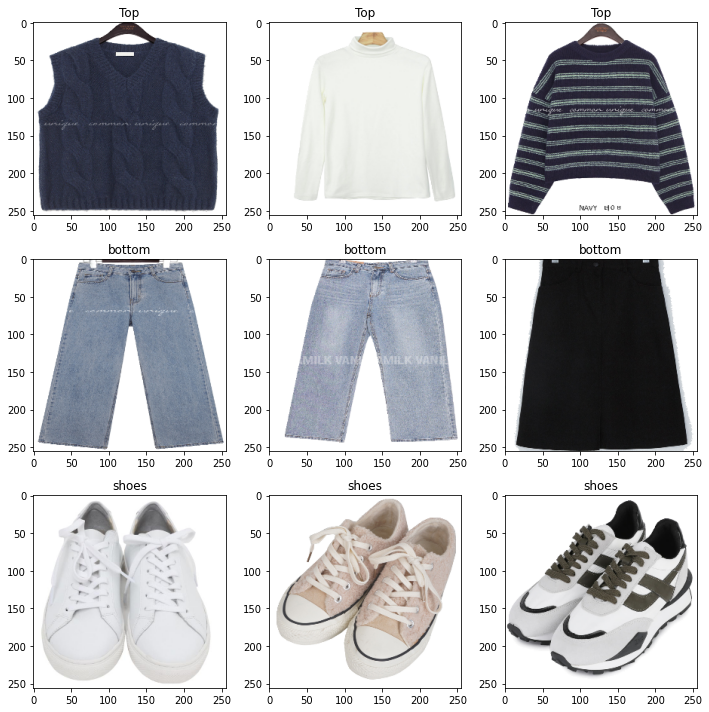

In [ ]:
def tag_recommendation(word):
  lst = []
  for k, v in dic.items():
    if word in v:
      lst.append(k)

  temp = []
  for idx in lst:
    for i in range(x_wx.shape[0]):
      temp.append((i, cos_sim(y_wy[idx],x_wx[i])))

  final = sorted(temp, key=lambda x: x[1], reverse=True)[:3]
  final = [x[0] for x in final]

  axes = []
  fig = plt.figure(figsize=(10, 10))
  for i, j, k in zip([1, 4, 7, 2, 5, 8, 3, 6, 9], ['Top', 'bottom', 'shoes']*3, list(chain.from_iterable(repeat(number, 3) for number in final))):
    axes.append(fig.add_subplot(3, 3, i))
    subplot_title = j
    axes[-1].set_title(subplot_title)

    if i in [1, 2, 3]:
      plt.imshow(x_top[k])
    elif i in [4, 5, 6]:
      plt.imshow(x_bottom[k])
    else:
      plt.imshow(x_shoes[k])

  fig.tight_layout()    
  plt.show()



# 태그 추천
tag_recommendation('꾸안꾸')